# Data description and preprocessing

1, Load dataset

In [5]:
import os
import pandas as pd
dataset_path = '/content/trash_dataset/TrashType_Image_Dataset'
garbage_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

dat = []
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    for file in os.listdir(folder_path):
        dat.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

df = pd.DataFrame(dat, columns=['filepath', 'label'])

2. Split

In [6]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Number of images in the data set: {len(df)}")
print(f"Number of images in the training set: {len(train_set)}")
print(f"Number of images in the test set: {len(test_set)}")

Number of images in the data set: 2527
Number of images in the training set: 2021
Number of images in the test set: 506


3. With Augmentation

In [ ]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator()

# Slight Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.05,
    brightness_range=[0.9, 1.1],
    channel_shift_range=10,
    fill_mode='nearest'
)

train_generator_aug = train_datagen.flow_from_dataframe(
    train_set,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    test_set,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


# Model Training

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(garbage_types), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator_aug, epochs=30, validation_data=test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.2507 - loss: 1.7650 - val_accuracy: 0.3933 - val_loss: 76.5388
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.3698 - loss: 1.5084 - val_accuracy: 0.4091 - val_loss: 137.5352
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.4122 - loss: 1.4764 - val_accuracy: 0.4111 - val_loss: 123.5954
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4476 - loss: 1.3531 - val_accuracy: 0.4130 - val_loss: 185.8962
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4756 - loss: 1.3760 - val_accuracy: 0.4012 - val_loss: 225.5956
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4932 - loss: 1.2836 - val_accuracy: 0.4387 - val_loss: 94.7351
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4938 - loss: 1.2920 - val_accuracy: 0.4407 - val_loss: 141.1428
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5286 - loss: 1.2309 - val_accuracy: 0.446

Model Evaluation

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.15      0.32      0.20        81
       glass       0.15      0.03      0.05       100
       metal       0.05      0.01      0.02        82
       paper       0.22      0.49      0.30       119
     plastic       0.07      0.01      0.02        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.18       506
   macro avg       0.11      0.14      0.10       506
weighted avg       0.13      0.18      0.12       506



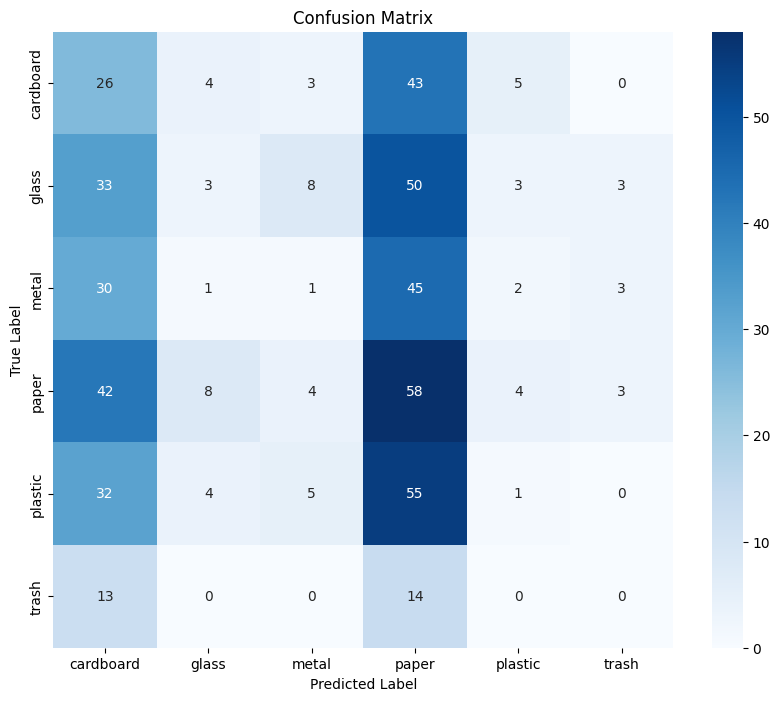

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = test_set['label'].tolist()
y_pred = model.predict(test_generator)

y_pred_labels = np.argmax(y_pred, axis=1)
class_labels = list(train_generator_aug.class_indices.keys())
y_true_labels = [class_labels.index(label) for label in y_true]

report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()